# Data Preprocessing

In [ ]:
# import packages
from google.colab import drive

# for data manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# for balancing data
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# for plotting data
import seaborn as sns
import matplotlib.pyplot as plt

# for feature selection
from sklearn.feature_selection import VarianceThreshold, RFECV

# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# for CNN
import torch
import torch.nn as nn
import torch.optim as optim

# evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix

# for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# global variables
STATE = 42


## Load Data

In [ ]:
# mount drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# load dataset
# you may need to update this depending on where your folders/files are
# a quick way for me was to add the shared folder as a shortcut to my drive to get it to show up when mounting
filepath = '/content/drive/MyDrive/CPSC 544 Group/heart.csv'

data = pd.read_csv(filepath)
data.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Remove Some Diseased Samples in Order to Simulate a 70:30 Data Imbalance

In [ ]:
# Assuming 'df' is your DataFrame and 'target' is the binary categorical feature
# Separate the data into two categories based on 'target'
healthySamples = data[data['HeartDisease'] == 0]  # All rows where target is 0
diseasedSamples = data[data['HeartDisease'] == 1]  # All rows where target is 1

# Determine how many rows to keep from each subset
healthyRatio = 0.7
diseasedRatio = 1 - healthyRatio

# Calculate the number of rows you want for each category
diseasedSampleCount = int((len(healthySamples) * diseasedRatio)/healthyRatio)

# Randomly sample the rows to match the desired distribution
diseasedSampled = diseasedSamples.sample(n=diseasedSampleCount, random_state=STATE)

# Concatenate the sampled dataframes
imbalancedData = pd.concat([healthySamples, diseasedSampled])

# Shuffle the resulting dataframe if necessary
imbalancedData = imbalancedData.sample(frac=1, random_state=STATE).reset_index(drop=True)

# Check the new distribution
print(imbalancedData['HeartDisease'].value_counts())

HeartDisease
0    410
1    175
Name: count, dtype: int64


In [ ]:
# check data types + nulls
imbalancedData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             585 non-null    int64  
 1   Sex             585 non-null    object 
 2   ChestPainType   585 non-null    object 
 3   RestingBP       585 non-null    int64  
 4   Cholesterol     585 non-null    int64  
 5   FastingBS       585 non-null    int64  
 6   RestingECG      585 non-null    object 
 7   MaxHR           585 non-null    int64  
 8   ExerciseAngina  585 non-null    object 
 9   Oldpeak         585 non-null    float64
 10  ST_Slope        585 non-null    object 
 11  HeartDisease    585 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 55.0+ KB


In [ ]:
# check distribution of numerical features
imbalancedData.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000,585.000000
mean,52.112821,131.552137,217.994872,0.165812,142.005128,0.682564,0.299145
std,9.693289,18.279164,93.599656,0.372230,24.759286,0.945250,0.458275
min,28.000000,0.000000,0.000000,0.000000,60.000000,-1.100000,0.000000
25%,45.000000,120.000000,195.000000,0.000000,125.000000,0.000000,0.000000
50%,53.000000,130.000000,226.000000,0.000000,142.000000,0.100000,0.000000
75%,59.000000,140.000000,268.000000,0.000000,161.000000,1.200000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,5.600000,1.000000


## Encode and Scale Data

In [ ]:
# split data into features and label
features = imbalancedData.drop('HeartDisease', axis=1)
label = imbalancedData['HeartDisease']

# split features into numerical and categorical
numerical = features.select_dtypes(exclude='object')
categorical = features.select_dtypes(include='object')

# encode categorical features
encoder = OneHotEncoder()
categorical_encoded = pd.DataFrame(encoder.fit_transform(categorical).toarray())
categorical_headers = encoder.get_feature_names_out(categorical.columns)
categorical_encoded.columns = categorical_headers

# scale numerical features
scaler = StandardScaler()
numerical_scaled = pd.DataFrame(scaler.fit_transform(numerical), columns=numerical.columns)

# merge encoded and scaled features
x = pd.concat([numerical_scaled, categorical_encoded], axis=1)
x.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,1.330633,1.283862,0.545395,-0.445837,0.242333,0.124344,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.457183,-1.453833,-2.331007,2.242973,0.969956,2.241998,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-1.044173,-0.632525,-0.213804,-0.445837,0.525298,-0.722717,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.020875,-1.180064,-2.331007,-0.445837,-0.889523,-0.193304,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.194856,0.243538,0.021441,-0.445837,-0.081054,2.453764,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


## Split Data into Training and Testing Sets

In [ ]:
# check balance of data
print(imbalancedData['HeartDisease'].value_counts())


HeartDisease
0    410
1    175
Name: count, dtype: int64


In [ ]:
# split into train-test (70% training, 30% testing)
x_train, x_test, y_train, y_test = train_test_split(x, label, test_size=0.30, stratify=label, random_state=STATE)


In [ ]:
x_train.shape

(409, 20)

# Balance Data

## Random Oversampling

In [ ]:
# https://medium.com/@tam.tamanna18/handling-imbalanced-datasets-in-python-methods-and-procedures-7376f99794de

o_minority_class = imbalancedData[imbalancedData['HeartDisease'] == 1]
o_majority_class = imbalancedData[imbalancedData['HeartDisease'] == 0]

# upsample minority class
oversampled = resample(o_minority_class, replace=True, n_samples=len(o_majority_class), random_state=STATE)
balanced_oversampled = pd.concat([o_majority_class, oversampled])

# check balance of data
print(balanced_oversampled['HeartDisease'].value_counts())

HeartDisease
0    410
1    410
Name: count, dtype: int64


In [ ]:
# split data into features and label
o_features = balanced_oversampled.drop('HeartDisease', axis=1)
o_label = balanced_oversampled['HeartDisease']

# split features into numerical and categorical
o_numerical = o_features.select_dtypes(exclude='object')
o_categorical = o_features.select_dtypes(include='object')

# encode categorical features
o_encoder = OneHotEncoder()
o_categorical_encoded = pd.DataFrame(o_encoder.fit_transform(o_categorical).toarray())
o_categorical_headers = o_encoder.get_feature_names_out(o_categorical.columns)
o_categorical_encoded.columns = o_categorical_headers

# scale numerical features
o_scaler = StandardScaler()
o_numerical_scaled = pd.DataFrame(o_scaler.fit_transform(o_numerical), columns=o_numerical.columns)

# merge encoded and scaled features
x_balanced_oversampled = pd.concat([o_numerical_scaled, o_categorical_encoded], axis=1)
x_balanced_oversampled.head(5)



,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,1.200851,1.183752,0.488978,-0.492366,0.402144,-0.080064,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,-1.179396,-0.615987,-0.201648,-0.492366,0.690286,-0.853582,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.454973,-0.101776,0.488978,-0.492366,1.019591,-0.853582,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.579917,0.412435,0.664067,-0.492366,0.484470,-0.853582,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
4,-0.558462,-0.101776,0.547341,-0.492366,0.031676,-0.660202,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
# split into train-test (70% training, 30% testing)
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(x_balanced_oversampled, o_label, test_size=0.30, stratify=o_label, random_state=STATE)


## Random Undersampling

In [ ]:
u_majority_class = imbalancedData[imbalancedData['HeartDisease'] == 0]
u_minority_class = imbalancedData[imbalancedData['HeartDisease'] == 1]

# downsample majority class
undersampled = resample(u_majority_class, replace=False, n_samples=len(u_minority_class), random_state=STATE)
balanced_undersampled = pd.concat([u_minority_class, undersampled])

# check balance of data
print(balanced_undersampled['HeartDisease'].value_counts())

HeartDisease
1    175
0    175
Name: count, dtype: int64


In [ ]:
# split data into features and label
u_features = balanced_undersampled.drop('HeartDisease', axis=1)
u_label = balanced_undersampled['HeartDisease']

# split features into numerical and categorical
u_numerical = u_features.select_dtypes(exclude='object')
u_categorical = u_features.select_dtypes(include='object')

# encode categorical features
u_encoder = OneHotEncoder()
u_categorical_encoded = pd.DataFrame(u_encoder.fit_transform(u_categorical).toarray())
u_categorical_headers = u_encoder.get_feature_names_out(u_categorical.columns)
u_categorical_encoded.columns = u_categorical_headers

# scale numerical features
u_scaler = StandardScaler()
u_numerical_scaled = pd.DataFrame(u_scaler.fit_transform(u_numerical), columns=u_numerical.columns)

# merge encoded and scaled features
x_balanced_undersampled = pd.concat([u_numerical_scaled, u_categorical_encoded], axis=1)
x_balanced_undersampled.head(5)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.676677,-1.450479,-2.065914,1.867399,1.223573,1.853588,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.878028,-1.186179,-2.065914,-0.535504,-0.687704,-0.357642,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.026459,0.188182,0.102448,-0.535504,0.143286,2.045869,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.771582,0.716782,0.309428,-0.535504,0.475682,2.045869,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4,-1.676677,-1.186179,-0.134101,-0.535504,1.223573,-0.838345,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0


In [ ]:
# split into train-test (70% training, 30% testing)
x_train_u, x_test_u, y_train_u, y_test_u = train_test_split(x_balanced_undersampled, u_label, test_size=0.30, stratify=u_label, random_state=STATE)


## SMOTE

In [ ]:
smote = SMOTE(random_state=STATE)
x_smote_resampled, y_smote_resampled = smote.fit_resample(x, label)

# check balance of data
print(y_smote_resampled.value_counts())

HeartDisease
0    410
1    410
Name: count, dtype: int64


In [ ]:
# split into train-test (70% training, 30% testing)
x_train_s, x_test_s, y_train_s, y_test_s = train_test_split(x_smote_resampled, y_smote_resampled, test_size=0.30, stratify=y_smote_resampled, random_state=STATE)


In [ ]:
datasets = {
    "imbalanced": {
        "x": x,
        "label": label,
        "x_train": x_train,
        "x_test": x_test,
        "y_train": y_train,
        "y_test": y_test,
        "x_encoded_features_train": None,
        "x_encoded_features_test": None
        },
    "oversampled": {
        "x": x_balanced_oversampled,
        "label": o_label,
        "x_train": x_train_o,
        "x_test": x_test_o,
        "y_train": y_train_o,
        "y_test": y_test_o,
        "x_encoded_features_train": None,
        "x_encoded_features_test": None
    },
    "undersampled": {
        "x": x_balanced_undersampled,
        "label": u_label,
        "x_train": x_train_u,
        "x_test": x_test_u,
        "y_train": y_train_u,
        "y_test": y_test_u,
        "x_encoded_features_train": None,
        "x_encoded_features_test": None
    },
    "SMOTE": {
        "x": x_smote_resampled,
        "label": y_smote_resampled,
        "x_train": x_train_s,
        "x_test": x_test_s,
        "y_train": y_train_s,
        "y_test": y_test_s,
        "x_encoded_features_train": None,
        "x_encoded_features_test": None
    }
}

---

# Feature Selection

## Recursive Feature Elimination with Cross-Validation (RFECV)

In [ ]:
# dictionary of classifiers
classifiers = {
    "Logistic Regression": {
        "model": LogisticRegression(random_state=STATE),
        "optimal_features_imbalanced": [],
        "optimal_features_oversampled": [],
        "optimal_features_undersampled": [],
        "optimal_features_SMOTE": [],
        "feature_importance_imbalanced": [],
        "feature_importance_oversampled": [],
        "feature_importance_undersampled": [],
        "feature_importance_SMOTE": [],
        "tree-based": False
        },
    "SVC": {
        "model": SVC(kernel='linear', random_state=STATE),
        "optimal_features_imbalanced": [],
        "optimal_features_oversampled": [],
        "optimal_features_undersampled": [],
        "optimal_features_SMOTE": [],
        "feature_importance_imbalanced": [],
        "feature_importance_oversampled": [],
        "feature_importance_undersampled": [],
        "feature_importance_SMOTE": [],
        "tree-based": False
        },
    "Decision Tree": {
        "model": DecisionTreeClassifier(random_state=STATE),
        "optimal_features_imbalanced": [],
        "optimal_features_oversampled": [],
        "optimal_features_undersampled": [],
        "optimal_features_SMOTE": [],
        "feature_importance_imbalanced": [],
        "feature_importance_oversampled": [],
        "feature_importance_undersampled": [],
        "feature_importance_SMOTE": [],
        "tree-based": True
        },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=STATE),
        "optimal_features_imbalanced": [],
        "optimal_features_oversampled": [],
        "optimal_features_undersampled": [],
        "optimal_features_SMOTE": [],
        "feature_importance_imbalanced": [],
        "feature_importance_oversampled": [],
        "feature_importance_undersampled": [],
        "feature_importance_SMOTE": [],
        "tree-based": True
        },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=STATE),
        "optimal_features_imbalanced": [],
        "optimal_features_oversampled": [],
        "optimal_features_undersampled": [],
        "optimal_features_SMOTE": [],
        "feature_importance_imbalanced": [],
        "feature_importance_oversampled": [],
        "feature_importance_undersampled": [],
        "feature_importance_SMOTE": [],
        "tree-based": True
        },
    "Extra Trees": {
        "model": ExtraTreesClassifier(random_state=STATE),
        "optimal_features_imbalanced": [],
        "optimal_features_oversampled": [],
        "optimal_features_undersampled": [],
        "optimal_features_SMOTE": [],
        "feature_importance_imbalanced": [],
        "feature_importance_oversampled": [],
        "feature_importance_undersampled": [],
        "feature_importance_SMOTE": [],
        "tree-based": True
        }
    }


--- Using imbalanced dataset ---
Total number of features: 20

Running Logistic Regression ...
Optimal number of features: 8
Features to keep: ['Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_TA', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']

Running SVC ...
Optimal number of features: 12
Features to keep: ['FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_TA', 'RestingECG_LVH', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']

Running Decision Tree ...
Optimal number of features: 11
Features to keep: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ASY', 'RestingECG_LVH', 'ExerciseAngina_N', 'ST_Slope_Up']

Running Random Forest ...
Optimal number of features: 12
Features to keep: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']


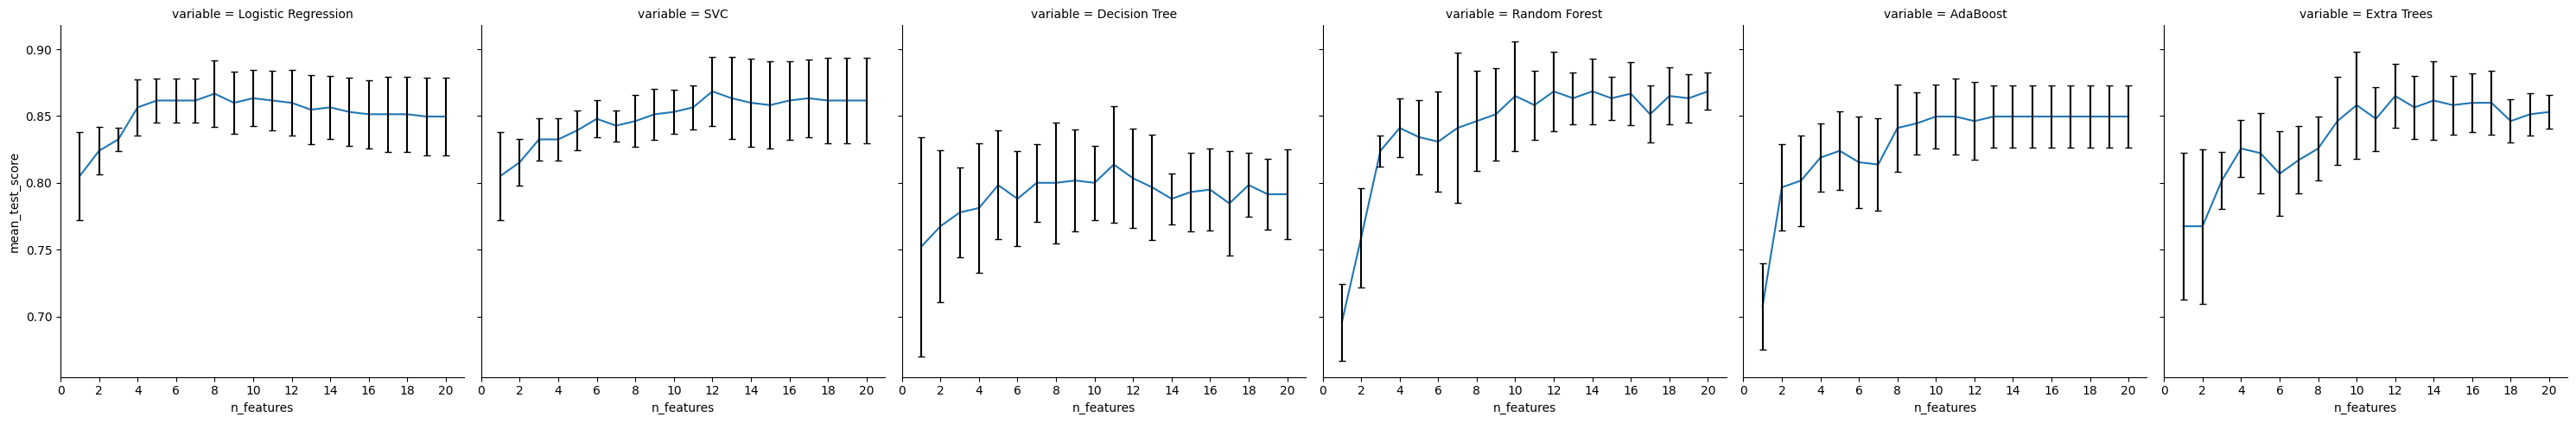


--- Using oversampled dataset ---
Total number of features: 20

Running Logistic Regression ...
Optimal number of features: 13
Features to keep: ['Age', 'FastingBS', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_TA', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']

Running SVC ...
Optimal number of features: 9
Features to keep: ['FastingBS', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_TA', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']

Running Decision Tree ...
Optimal number of features: 18
Features to keep: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']

Running Random Forest ...
Optimal number of features: 12
Features to keep: ['Age', '

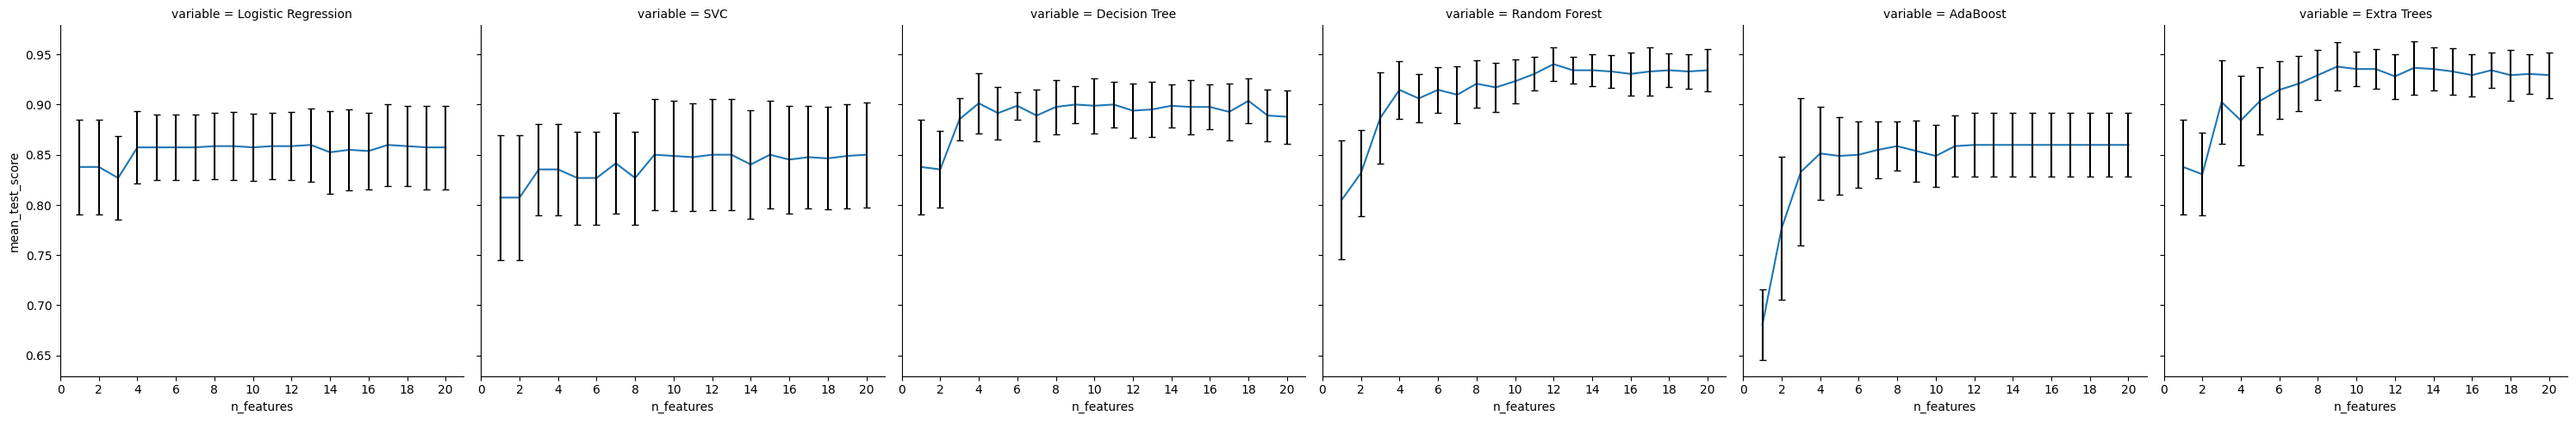


--- Using undersampled dataset ---
Total number of features: 20

Running Logistic Regression ...
Optimal number of features: 5
Features to keep: ['Sex_M', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ST_Slope_Flat', 'ST_Slope_Up']

Running SVC ...
Optimal number of features: 12
Features to keep: ['FastingBS', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_NAP', 'ChestPainType_TA', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']

Running Decision Tree ...
Optimal number of features: 20
Features to keep: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']

Running Random Forest ...
Optimal number of features: 20
Features to keep: ['Age', 'RestingBP', 'Cholesterol', 'Fasting

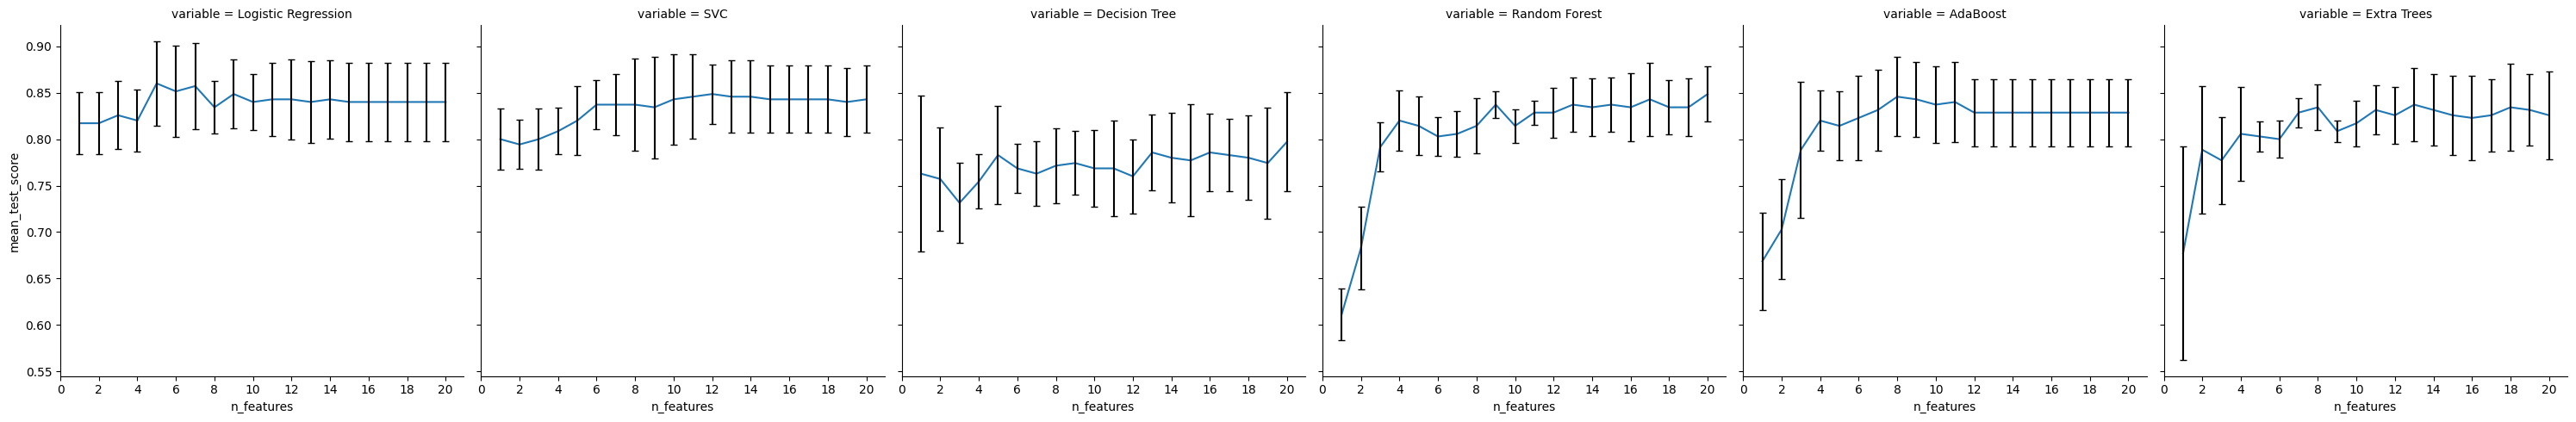


--- Using SMOTE dataset ---
Total number of features: 20

Running Logistic Regression ...
Optimal number of features: 13
Features to keep: ['Age', 'FastingBS', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']

Running SVC ...
Optimal number of features: 8
Features to keep: ['FastingBS', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ExerciseAngina_N', 'ExerciseAngina_Y', 'ST_Slope_Flat', 'ST_Slope_Up']

Running Decision Tree ...
Optimal number of features: 11
Features to keep: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_M', 'ChestPainType_ASY', 'RestingECG_ST', 'ExerciseAngina_N', 'ST_Slope_Up']

Running Random Forest ...
Optimal number of features: 18
Features to keep: ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'Sex_F', 'Sex_M', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'Resti

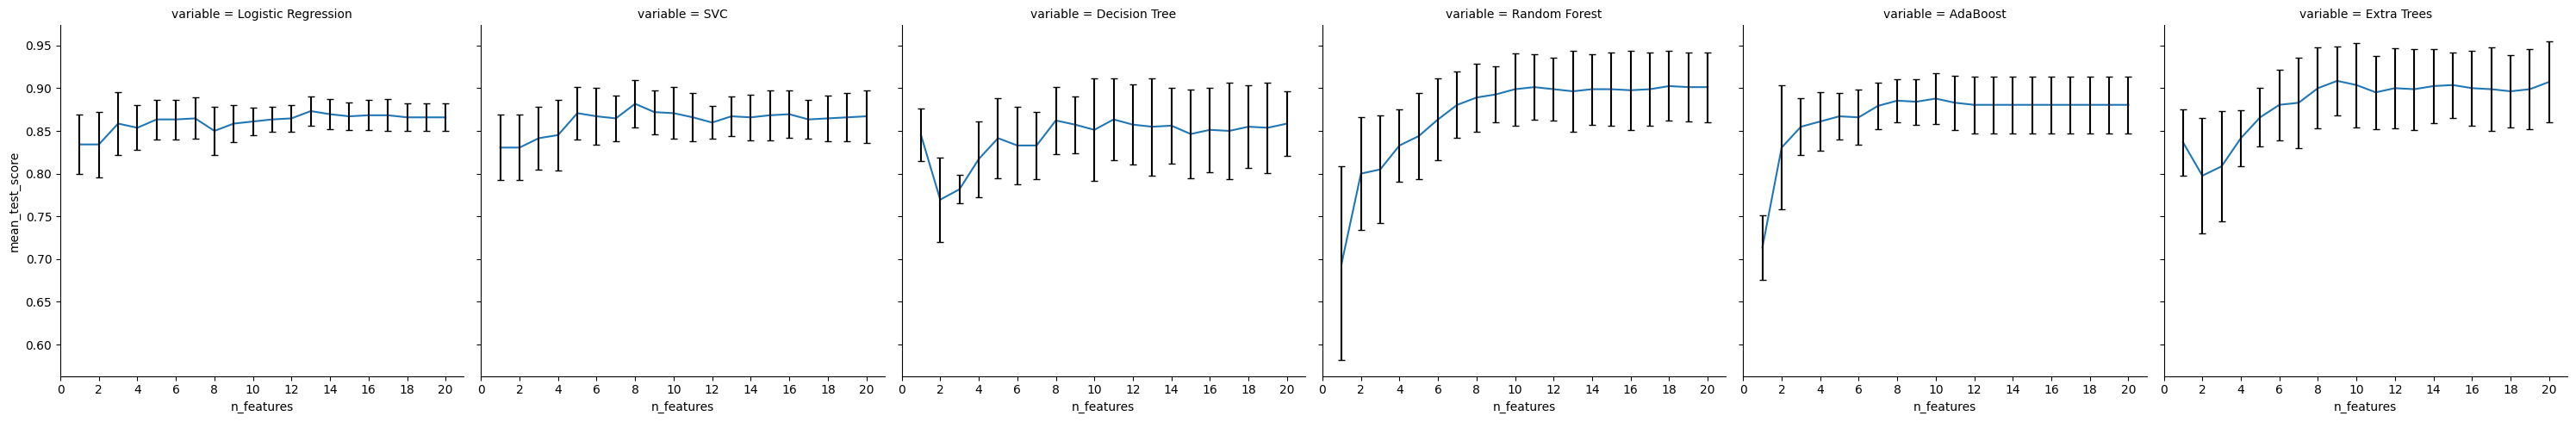

In [ ]:
for dataset_name, dataset in datasets.items():
    print(f"\n--- Using {dataset_name} dataset ---")

    x = dataset['x']
    label = dataset['label']

    # lists for plots
    means = []
    st_devs = []
    feature_importance = []

    # total number of features
    print(f"Total number of features: {x.shape[1]}\n")

    # run recursive feature elimination with cross validation
    for name, classifier in classifiers.items():
        print(f"Running {name} ...")
        RFECV_selector = RFECV(classifier['model'], step=1, cv=5, scoring='accuracy', min_features_to_select=1, n_jobs=-1)
        RFECV_selector.fit(x, label)
        print(f"Optimal number of features: {RFECV_selector.n_features_}")

        for i in range(len(RFECV_selector.ranking_)):
            if (RFECV_selector.ranking_[i] == 1):
                classifier[f'optimal_features_{dataset_name}'].append(x.columns[i])

        print(f"Features to keep: {classifier[f'optimal_features_{dataset_name}']}\n")

        # save mean score for plot
        mean_score = pd.DataFrame(RFECV_selector.cv_results_, columns=['mean_test_score', 'n_features'])
        mean_score = mean_score.rename(columns={"mean_test_score" : name})
        mean_score = pd.melt(mean_score, id_vars=['n_features'])
        means.append(mean_score)

        # save std score for plot
        std_score = pd.DataFrame(RFECV_selector.cv_results_, columns=['std_test_score', 'n_features'])
        std_score = std_score.rename(columns={"std_test_score" : name})
        std_score = pd.melt(std_score, id_vars=['n_features'])
        st_devs.append(std_score)

        # get feature importance
        if classifier['tree-based'] == True:
            m = classifier['model'].fit(x, label)
            fi = pd.Series(m.feature_importances_, index=x.columns)
            fi.sort_values(ascending=False, inplace=True)
            classifier[f'feature_importance_{dataset_name}'].append(fi)
        else:
            m = classifier['model'].fit(x, label)
            fi = pd.Series(m.coef_[0], index=x.columns)
            fi.sort_values(ascending=False, inplace=True)
            classifier[f'feature_importance_{dataset_name}'].append(fi)


    # merge means and st devs into one table
    combined_means = pd.concat(means)
    combined_means = combined_means.rename(columns={"value" : "mean_test_score"})
    combined_st_devs = pd.concat(st_devs)
    combined_st_devs = combined_st_devs.rename(columns={"value" : "std_test_score"})
    results = pd.concat([combined_means, combined_st_devs], axis=1)
    results = results.loc[:,~results.columns.duplicated()]

    # plot RFECV results
    with sns.color_palette():
        g = sns.relplot(data=results, x='n_features', y='mean_test_score', col='variable', kind='line', facet_kws=dict(sharex=False), legend='full')

    # plot error bars
    filtered = []
    for name in classifiers:
        filtered.append(results[results['variable'] == name])

    for i, ax in enumerate(plt.gcf().axes):
        ax.errorbar(filtered[i]['n_features'], filtered[i]['mean_test_score'], yerr=filtered[i]['std_test_score'], fmt='none', color='black', capsize=3)

        # # modify x-axis interval
        min_x = int(ax.get_xlim()[0])
        max_x = int(ax.get_xlim()[1])
        ax.set_xticks(range(min_x, max_x + 1, 2))
        ax.set_xticklabels(range(min_x, max_x + 1, 2))

    plt.show()

---

# Models

Note: I tried training each generic model with all vs optimal number of features just to check if they really did perform better. Tested models scored between 78-88% accuracy. Difference between all vs optimal number of features was small (0-2%).

In [ ]:
# prints classification report and confusion matrix
def evaluate_model(y_test, y_pred):
  print("Classification Report:")
  print(classification_report(y_test, y_pred))
  print("Confusion Matrix:")
  print(confusion_matrix(y_test, y_pred))

In [ ]:
# returns dataset with only optimal features
def get_optimal_features(model_name, dataset, dataset_name):
  # get optimal features
  opt_features_model = classifiers[model_name][f'optimal_features_{dataset_name}']
  return dataset[opt_features_model]

In [ ]:
# evaluates model with optimal vs all features
def optimal_vs_all_features(model_name):
  for dataset_name, dataset in datasets.items():
    x_train = dataset['x_train']
    x_test = dataset['x_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']

    x_train_model = get_optimal_features(model_name, x_train, dataset_name)
    x_test_model = get_optimal_features(model_name, x_test, dataset_name)

    # train with optimal features
    opt_model = classifiers[model_name]['model']
    opt_model.fit(x_train_model, y_train)

    opt_y_pred = opt_model.predict(x_test_model)
    print(f"----- {model_name} [{dataset_name} dataset: {len(classifiers[model_name][f'optimal_features_{dataset_name}'])} features] -----")
    evaluate_model(y_test, opt_y_pred)

    # train with all features
    model = classifiers[model_name]['model']
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)
    print(f"\n----- {model_name} [{dataset_name} dataset: all features] -----")
    evaluate_model(y_test, y_pred)


## Logistic Regression

In [ ]:
optimal_vs_all_features('Logistic Regression')

----- Logistic Regression [imbalanced dataset: 8 features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       123
           1       0.70      0.72      0.71        53

    accuracy                           0.82       176
   macro avg       0.79      0.79      0.79       176
weighted avg       0.82      0.82      0.82       176

Confusion Matrix:
[[107  16]
 [ 15  38]]

----- Logistic Regression [imbalanced dataset: all features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       123
           1       0.76      0.72      0.74        53

    accuracy                           0.85       176
   macro avg       0.82      0.81      0.81       176
weighted avg       0.84      0.85      0.85       176

Confusion Matrix:
[[111  12]
 [ 15  38]]
----- Logistic Regression [oversampled dataset: 13 features] -----
Classification Rep

## SVC

In [ ]:
optimal_vs_all_features('SVC')

----- SVC [imbalanced dataset: 12 features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       123
           1       0.74      0.74      0.74        53

    accuracy                           0.84       176
   macro avg       0.81      0.81      0.81       176
weighted avg       0.84      0.84      0.84       176

Confusion Matrix:
[[109  14]
 [ 14  39]]

----- SVC [imbalanced dataset: all features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88       123
           1       0.72      0.74      0.73        53

    accuracy                           0.84       176
   macro avg       0.80      0.81      0.81       176
weighted avg       0.84      0.84      0.84       176

Confusion Matrix:
[[108  15]
 [ 14  39]]
----- SVC [oversampled dataset: 9 features] -----
Classification Report:
              precision    recall  f1-score

## Decision Tree

In [ ]:
optimal_vs_all_features('Decision Tree')

----- Decision Tree [imbalanced dataset: 11 features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       123
           1       0.73      0.62      0.67        53

    accuracy                           0.82       176
   macro avg       0.79      0.76      0.77       176
weighted avg       0.81      0.82      0.81       176

Confusion Matrix:
[[111  12]
 [ 20  33]]

----- Decision Tree [imbalanced dataset: all features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       123
           1       0.70      0.62      0.66        53

    accuracy                           0.81       176
   macro avg       0.77      0.75      0.76       176
weighted avg       0.80      0.81      0.80       176

Confusion Matrix:
[[109  14]
 [ 20  33]]
----- Decision Tree [oversampled dataset: 18 features] -----
Classification Report:
            

## Random Forest

In [ ]:
optimal_vs_all_features('Random Forest')

----- Random Forest [imbalanced dataset: 12 features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       123
           1       0.80      0.74      0.76        53

    accuracy                           0.86       176
   macro avg       0.84      0.83      0.83       176
weighted avg       0.86      0.86      0.86       176

Confusion Matrix:
[[113  10]
 [ 14  39]]

----- Random Forest [imbalanced dataset: all features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       123
           1       0.78      0.68      0.73        53

    accuracy                           0.85       176
   macro avg       0.83      0.80      0.81       176
weighted avg       0.84      0.85      0.84       176

Confusion Matrix:
[[113  10]
 [ 17  36]]
----- Random Forest [oversampled dataset: 12 features] -----
Classification Report:
            

## AdaBoost

In [ ]:
optimal_vs_all_features('AdaBoost')

----- AdaBoost [imbalanced dataset: 10 features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       123
           1       0.75      0.72      0.73        53

    accuracy                           0.84       176
   macro avg       0.81      0.81      0.81       176
weighted avg       0.84      0.84      0.84       176

Confusion Matrix:
[[110  13]
 [ 15  38]]

----- AdaBoost [imbalanced dataset: all features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       123
           1       0.77      0.68      0.72        53

    accuracy                           0.84       176
   macro avg       0.82      0.79      0.80       176
weighted avg       0.84      0.84      0.84       176

Confusion Matrix:
[[112  11]
 [ 17  36]]
----- AdaBoost [oversampled dataset: 12 features] -----
Classification Report:
              precision    

## Extra Trees

In [ ]:
optimal_vs_all_features('Extra Trees')

----- Extra Trees [imbalanced dataset: 12 features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       123
           1       0.75      0.68      0.71        53

    accuracy                           0.84       176
   macro avg       0.81      0.79      0.80       176
weighted avg       0.83      0.84      0.83       176

Confusion Matrix:
[[111  12]
 [ 17  36]]

----- Extra Trees [imbalanced dataset: all features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       123
           1       0.73      0.68      0.71        53

    accuracy                           0.83       176
   macro avg       0.80      0.79      0.79       176
weighted avg       0.83      0.83      0.83       176

Confusion Matrix:
[[110  13]
 [ 17  36]]
----- Extra Trees [oversampled dataset: 9 features] -----
Classification Report:
              preci

## K-Nearest Neighbours


--- Using imbalanced dataset ---
best testing accuracy: 0.8750 (k=5)



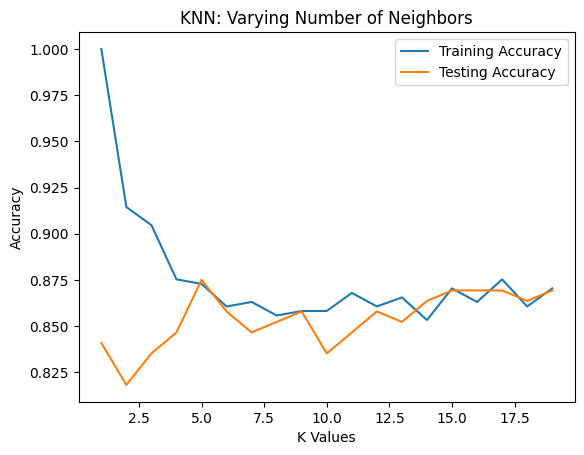


--- Using oversampled dataset ---
best testing accuracy: 0.8984 (k=1)



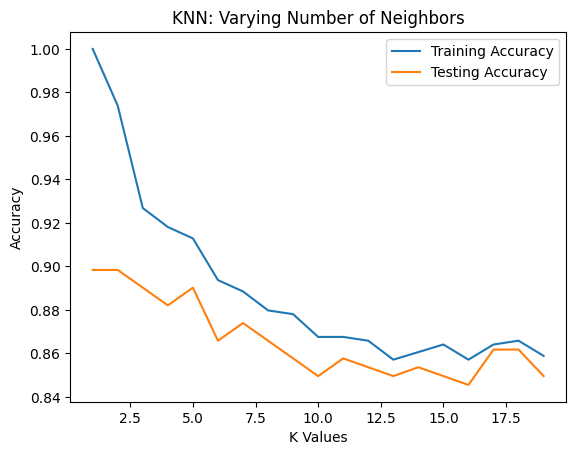


--- Using undersampled dataset ---
best testing accuracy: 0.8857 (k=1)



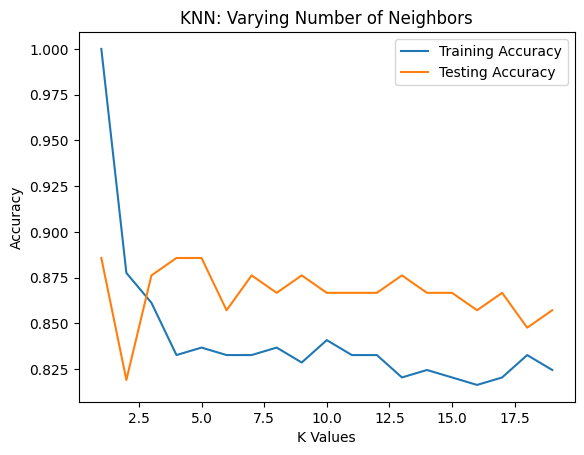


--- Using SMOTE dataset ---
best testing accuracy: 0.9065 (k=1)



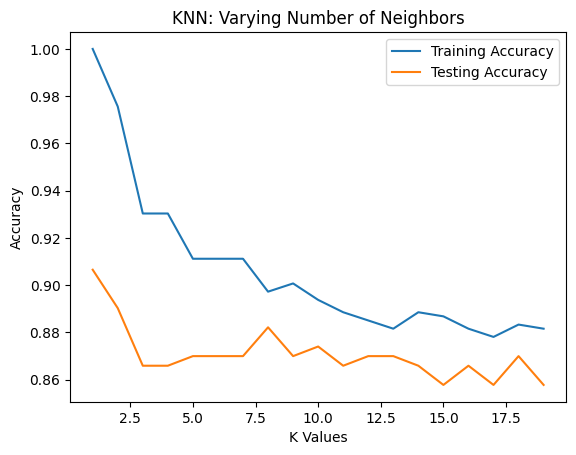

In [ ]:
# https://www.w3resource.com/machine-learning/scikit-learn/iris/python-machine-learning-k-nearest-neighbors-algorithm-exercise-8.php

for dataset_name, dataset in datasets.items():
    print(f"\n--- Using {dataset_name} dataset ---")

    x_train = dataset['x_train']
    x_test = dataset['x_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']

    train_score = []
    test_score = []
    k_values = np.arange(1, 20)
    best_test_score = 0
    best_k = 0

    for k in range(1, 20):
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(x_train, y_train)

      # knn_y_pred = knn.predict(x_test)
      # print(f"----- K-Nearest Neighbours [k = {k}] -----")
      # evaluate_model(y_test, knn_y_pred)

      train_score.append(knn.score(x_train, y_train))
      test_score.append(knn.score(x_test, y_test))

      if (test_score[k-1] > best_test_score):
        best_test_score = test_score[k-1]
        best_k = k

    print(f'best testing accuracy: {best_test_score:.4f} (k={best_k})\n')

    plt.title('KNN: Varying Number of Neighbors')
    plt.plot(k_values, train_score, label = 'Training Accuracy')
    plt.plot(k_values, test_score, label = 'Testing Accuracy')
    plt.legend()
    plt.xlabel('K Values')
    plt.ylabel('Accuracy')
    plt.show()


## Multilayer Perceptron

In [ ]:
for dataset_name, dataset in datasets.items():
    x_train = dataset['x_train']
    x_test = dataset['x_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']

    mlp = MLPClassifier(random_state=STATE)
    mlp.fit(x_train, y_train)

    mlp_y_pred = mlp.predict(x_test)
    print(f"----- Multilayer Perceptron [{dataset_name} dataset: all features] -----")
    evaluate_model(y_test, mlp_y_pred)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


----- Multilayer Perceptron [imbalanced dataset: all features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       123
           1       0.80      0.75      0.78        53

    accuracy                           0.87       176
   macro avg       0.85      0.84      0.84       176
weighted avg       0.87      0.87      0.87       176

Confusion Matrix:
[[113  10]
 [ 13  40]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


----- Multilayer Perceptron [oversampled dataset: all features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       123
           1       0.92      0.92      0.92       123

    accuracy                           0.92       246
   macro avg       0.92      0.92      0.92       246
weighted avg       0.92      0.92      0.92       246

Confusion Matrix:
[[113  10]
 [ 10 113]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


----- Multilayer Perceptron [undersampled dataset: all features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90        53
           1       0.89      0.90      0.90        52

    accuracy                           0.90       105
   macro avg       0.90      0.90      0.90       105
weighted avg       0.90      0.90      0.90       105

Confusion Matrix:
[[47  6]
 [ 5 47]]
----- Multilayer Perceptron [SMOTE dataset: all features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       123
           1       0.89      0.86      0.88       123

    accuracy                           0.88       246
   macro avg       0.88      0.88      0.88       246
weighted avg       0.88      0.88      0.88       246

Confusion Matrix:
[[110  13]
 [ 17 106]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(20, 1024),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(1024, 128),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(128, 10),

        )

        self.decoder = nn.Sequential(
            nn.ReLU(), # or nn.Sigmoid()
            nn.Linear(10, 15),
            nn.ReLU(),
            nn.Linear(15, 20),
        )

    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

    def get_encoded_features(self, x):
      x = self.encoder(x)
      return x


In [ ]:
x_train_tensor = []
y_train_tensor = []

x_test_tensor = []
y_test_tensor = []

for i, (dataset_name, dataset) in enumerate(datasets.items()):
    print(f"--- {dataset_name} ---")
    x_train = dataset['x_train']
    x_test = dataset['x_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']

    print(f"x_train: {x_train.shape}")

    x_train_tensor.append(torch.tensor(np.array(x_train).reshape(x_train.shape[0], 1, x_train.shape[1]), dtype=torch.float32))
    y_train_tensor.append(torch.tensor(y_train, dtype=torch.float32).view(-1, 1))

    x_test_tensor.append(torch.tensor(np.array(x_test).reshape(x_test.shape[0], 1, x_test.shape[1]), dtype=torch.float32))
    y_test_tensor.append(torch.tensor(np.array(y_test), dtype=torch.float32).view(-1, 1))

    print(f"x_train shape: {x_train_tensor[i].shape}")
    print(f"y_train shape: {y_train_tensor[i].shape}")

    print(f"x_test shape: {x_test_tensor[i].shape}")
    print(f"y_test shape: {y_test_tensor[i].shape}")

--- imbalanced ---
x_train: (409, 20)
x_train shape: torch.Size([409, 1, 20])
y_train shape: torch.Size([409, 1])
x_test shape: torch.Size([176, 1, 20])
y_test shape: torch.Size([176, 1])
--- oversampled ---
x_train: (574, 20)
x_train shape: torch.Size([574, 1, 20])
y_train shape: torch.Size([574, 1])
x_test shape: torch.Size([246, 1, 20])
y_test shape: torch.Size([246, 1])
--- undersampled ---
x_train: (245, 20)
x_train shape: torch.Size([245, 1, 20])
y_train shape: torch.Size([245, 1])
x_test shape: torch.Size([105, 1, 20])
y_test shape: torch.Size([105, 1])
--- SMOTE ---
x_train: (574, 20)
x_train shape: torch.Size([574, 1, 20])
y_train shape: torch.Size([574, 1])
x_test shape: torch.Size([246, 1, 20])
y_test shape: torch.Size([246, 1])


In [ ]:
torch.manual_seed(42)

models = []

num_epochs = 100
batch_size = 32

for n, (dataset_name, dataset) in enumerate(datasets.items()):
    print(f"--- {dataset_name} ---")

    model = Autoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        # train model
        model.train()

        running_train_loss = 0.0
        total_train_batches = 0

        # Split the training data into batches
        for i in range(0, x_train_tensor[n].size(0), batch_size):
            x_train_batch = x_train_tensor[n][i:i+batch_size]

            # add noise to data
            factor = 0.1
            x_train_batch_noise = x_train_batch + factor * torch.randn_like(x_train_batch)

            optimizer.zero_grad()
            outputs = model(x_train_batch_noise)
            loss = criterion(outputs, x_train_batch_noise)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            total_train_batches += 1

        avg_train_loss = running_train_loss / total_train_batches

        # test model
        model.eval()
        running_test_loss = 0.0
        total_test_batches = 0

        with torch.no_grad():
          for i in range(0, x_test_tensor[n].size(0), batch_size):
            x_test_batch = x_test_tensor[n][i:i+batch_size]

            outputs = model(x_test_batch)
            loss = criterion(outputs, x_test_batch)

            running_test_loss += loss.item()
            total_test_batches += 1

        avg_test_loss = running_test_loss / total_test_batches

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}')

    models.append(model)

--- imbalanced ---
Epoch [1/100] Train Loss: 0.5099 | Test Loss: 0.4689
Epoch [2/100] Train Loss: 0.4314 | Test Loss: 0.4114
Epoch [3/100] Train Loss: 0.3855 | Test Loss: 0.3660
Epoch [4/100] Train Loss: 0.3489 | Test Loss: 0.3338
Epoch [5/100] Train Loss: 0.3204 | Test Loss: 0.3085
Epoch [6/100] Train Loss: 0.3019 | Test Loss: 0.2885
Epoch [7/100] Train Loss: 0.2842 | Test Loss: 0.2723
Epoch [8/100] Train Loss: 0.2668 | Test Loss: 0.2546
Epoch [9/100] Train Loss: 0.2502 | Test Loss: 0.2402
Epoch [10/100] Train Loss: 0.2363 | Test Loss: 0.2275
Epoch [11/100] Train Loss: 0.2256 | Test Loss: 0.2175
Epoch [12/100] Train Loss: 0.2147 | Test Loss: 0.2066
Epoch [13/100] Train Loss: 0.2051 | Test Loss: 0.1972
Epoch [14/100] Train Loss: 0.1977 | Test Loss: 0.1880
Epoch [15/100] Train Loss: 0.1881 | Test Loss: 0.1780
Epoch [16/100] Train Loss: 0.1834 | Test Loss: 0.1704
Epoch [17/100] Train Loss: 0.1744 | Test Loss: 0.1607
Epoch [18/100] Train Loss: 0.1658 | Test Loss: 0.1517
Epoch [19/100] Tra

In [ ]:
for i, (dataset_name, dataset) in enumerate(datasets.items()):
    print(f"--- {dataset_name} ---")
    x_encoded_features_train = []
    x_encoded_features_test = []

    for x in x_train_tensor[i]:
      coded = models[i].get_encoded_features(x)
      x_encoded_features_train.append(coded.detach().numpy())

    for x in x_test_tensor[i]:
      coded = models[i].get_encoded_features(x)
      x_encoded_features_test.append(coded.detach().numpy())

    x_encoded_features_train = np.array(x_encoded_features_train)
    x_encoded_features_test = np.array(x_encoded_features_test)

    x_encoded_features_train = x_encoded_features_train.squeeze(1)
    x_encoded_features_test = x_encoded_features_test.squeeze(1)

    dataset['x_encoded_features_train'] = x_encoded_features_train
    dataset['x_encoded_features_test'] = x_encoded_features_test

    print(x_encoded_features_train.shape)


# x_encoded_features_train = []
# x_encoded_features_test = []

# for x in x_train_tensor:
#   coded = model.get_encoded_features(x)
#   x_encoded_features_train.append(coded.detach().numpy())

# for x in x_test_tensor:
#   coded = model.get_encoded_features(x)
#   x_encoded_features_test.append(coded.detach().numpy())

# x_encoded_features_train = np.array(x_encoded_features_train)
# x_encoded_features_test = np.array(x_encoded_features_test)

# x_encoded_features_train = x_encoded_features_train.squeeze(1)
# x_encoded_features_test = x_encoded_features_test.squeeze(1)

# print(x_encoded_features_train.shape)

--- imbalanced ---
(409, 10)
--- oversampled ---
(574, 10)
--- undersampled ---
(245, 10)
--- SMOTE ---
(574, 10)


In [ ]:
# evaluates model with encoded features
def experiment_encoded(model_name):
  for dataset_name, dataset in datasets.items():
    x_encoded_features_train = dataset['x_encoded_features_train']
    x_encoded_features_test = dataset['x_encoded_features_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']

    model = classifiers[model_name]['model']
    model.fit(x_encoded_features_train, y_train)

    y_pred = model.predict(x_encoded_features_test)
    print(f"\n----- {model_name} [{dataset_name}: encoded features] -----")
    evaluate_model(y_test, y_pred)

### Logistic Regression + Autoencoder Features

In [ ]:
experiment_encoded('Logistic Regression')


----- Logistic Regression [imbalanced: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       123
           1       0.78      0.72      0.75        53

    accuracy                           0.85       176
   macro avg       0.83      0.81      0.82       176
weighted avg       0.85      0.85      0.85       176

Confusion Matrix:
[[112  11]
 [ 15  38]]

----- Logistic Regression [oversampled: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       123
           1       0.87      0.84      0.85       123

    accuracy                           0.86       246
   macro avg       0.86      0.86      0.86       246
weighted avg       0.86      0.86      0.86       246

Confusion Matrix:
[[108  15]
 [ 20 103]]

----- Logistic Regression [undersampled: encoded features] -----
Classification Report:


### SVC + Autoencoder Features

In [ ]:
experiment_encoded('SVC')


----- SVC [imbalanced: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       123
           1       0.78      0.75      0.77        53

    accuracy                           0.86       176
   macro avg       0.84      0.83      0.84       176
weighted avg       0.86      0.86      0.86       176

Confusion Matrix:
[[112  11]
 [ 13  40]]

----- SVC [oversampled: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       123
           1       0.87      0.85      0.86       123

    accuracy                           0.86       246
   macro avg       0.86      0.86      0.86       246
weighted avg       0.86      0.86      0.86       246

Confusion Matrix:
[[107  16]
 [ 18 105]]

----- SVC [undersampled: encoded features] -----
Classification Report:
              precision    recall  f1-score   su

### Decision Tree + Autoencoder Features

In [ ]:
experiment_encoded('Decision Tree')


----- Decision Tree [imbalanced: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       123
           1       0.59      0.66      0.62        53

    accuracy                           0.76       176
   macro avg       0.72      0.73      0.72       176
weighted avg       0.77      0.76      0.76       176

Confusion Matrix:
[[99 24]
 [18 35]]

----- Decision Tree [oversampled: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       123
           1       0.81      0.86      0.83       123

    accuracy                           0.83       246
   macro avg       0.83      0.83      0.83       246
weighted avg       0.83      0.83      0.83       246

Confusion Matrix:
[[ 98  25]
 [ 17 106]]

----- Decision Tree [undersampled: encoded features] -----
Classification Report:
              precisio

### Random Forest + Autoencoder Features

In [ ]:
experiment_encoded('Random Forest')


----- Random Forest [imbalanced: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       123
           1       0.76      0.60      0.67        53

    accuracy                           0.82       176
   macro avg       0.80      0.76      0.78       176
weighted avg       0.82      0.82      0.82       176

Confusion Matrix:
[[113  10]
 [ 21  32]]

----- Random Forest [oversampled: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       123
           1       0.88      0.93      0.91       123

    accuracy                           0.90       246
   macro avg       0.90      0.90      0.90       246
weighted avg       0.90      0.90      0.90       246

Confusion Matrix:
[[107  16]
 [  8 115]]

----- Random Forest [undersampled: encoded features] -----
Classification Report:
              prec

### AdaBoost + Autoencoder Features

In [ ]:
experiment_encoded('AdaBoost')


----- AdaBoost [imbalanced: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88       123
           1       0.77      0.62      0.69        53

    accuracy                           0.83       176
   macro avg       0.81      0.77      0.79       176
weighted avg       0.82      0.83      0.82       176

Confusion Matrix:
[[113  10]
 [ 20  33]]

----- AdaBoost [oversampled: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       123
           1       0.87      0.85      0.86       123

    accuracy                           0.86       246
   macro avg       0.86      0.86      0.86       246
weighted avg       0.86      0.86      0.86       246

Confusion Matrix:
[[107  16]
 [ 18 105]]

----- AdaBoost [undersampled: encoded features] -----
Classification Report:
              precision    recall

### Extra Trees + Autoencoder Features

In [ ]:
experiment_encoded('Extra Trees')


----- Extra Trees [imbalanced: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89       123
           1       0.77      0.64      0.70        53

    accuracy                           0.84       176
   macro avg       0.81      0.78      0.79       176
weighted avg       0.83      0.84      0.83       176

Confusion Matrix:
[[113  10]
 [ 19  34]]

----- Extra Trees [oversampled: encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       123
           1       0.93      0.93      0.93       123

    accuracy                           0.93       246
   macro avg       0.93      0.93      0.93       246
weighted avg       0.93      0.93      0.93       246

Confusion Matrix:
[[114   9]
 [  9 114]]

----- Extra Trees [undersampled: encoded features] -----
Classification Report:
              precision 

### KNN + Autoencoder Features


--- Using imbalanced dataset ---
best testing accuracy: 0.8580 (k=15)



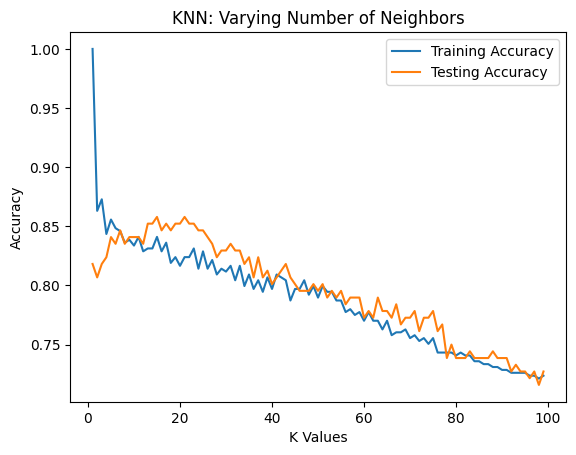


--- Using oversampled dataset ---
best testing accuracy: 0.8902 (k=1)



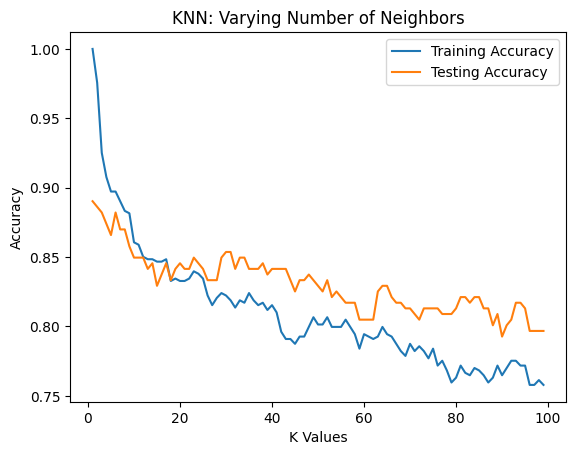


--- Using undersampled dataset ---
best testing accuracy: 0.8857 (k=7)



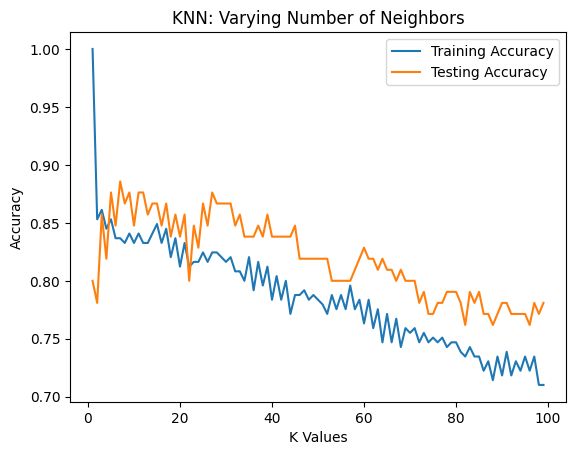


--- Using SMOTE dataset ---
best testing accuracy: 0.8780 (k=6)



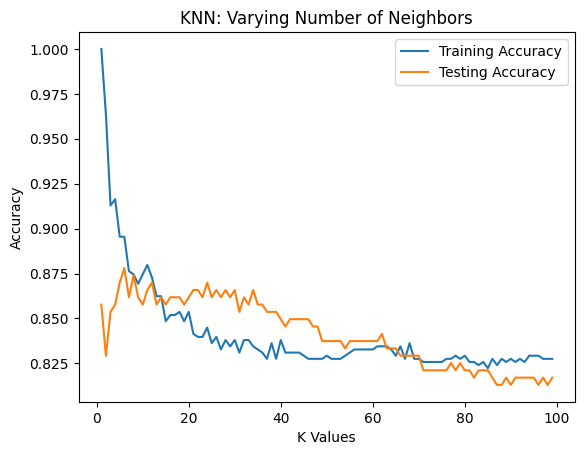

In [ ]:
# train with encoded features
# https://www.w3resource.com/machine-learning/scikit-learn/iris/python-machine-learning-k-nearest-neighbors-algorithm-exercise-8.php


for dataset_name, dataset in datasets.items():
    print(f"\n--- Using {dataset_name} dataset ---")

    x_encoded_features_train = dataset['x_encoded_features_train']
    x_encoded_features_test = dataset['x_encoded_features_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']

    train_score = []
    test_score = []
    k_values = np.arange(1, 100)
    best_test_score = 0
    best_k = 0

    for k in range(1, 100):
      knn = KNeighborsClassifier(n_neighbors=k)
      knn.fit(x_encoded_features_train, y_train)

      # knn_y_pred = knn.predict(x_test)
      # print(f"----- K-Nearest Neighbours [k = {k}] -----")
      # evaluate_model(y_test, knn_y_pred)

      train_score.append(knn.score(x_encoded_features_train, y_train))
      test_score.append(knn.score(x_encoded_features_test, y_test))

      if (test_score[k-1] > best_test_score):
        best_test_score = test_score[k-1]
        best_k = k

    print(f'best testing accuracy: {best_test_score:.4f} (k={best_k})\n')

    plt.title('KNN: Varying Number of Neighbors')
    plt.plot(k_values, train_score, label = 'Training Accuracy')
    plt.plot(k_values, test_score, label = 'Testing Accuracy')
    plt.legend()
    plt.xlabel('K Values')
    plt.ylabel('Accuracy')
    plt.show()

### MLP + Autoencoder Features

In [ ]:
for dataset_name, dataset in datasets.items():
    print(f"\n--- Using {dataset_name} dataset ---")

    x_encoded_features_train = dataset['x_encoded_features_train']
    x_encoded_features_test = dataset['x_encoded_features_test']
    y_train = dataset['y_train']
    y_test = dataset['y_test']

    mlp = MLPClassifier(random_state=STATE)
    mlp.fit(x_encoded_features_train, y_train)

    mlp_y_pred = mlp.predict(x_encoded_features_test)
    print(f"----- Multilayer Perceptron [encoded features] -----")
    evaluate_model(y_test, mlp_y_pred)


--- Using imbalanced dataset ---


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


----- Multilayer Perceptron [encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       123
           1       0.76      0.77      0.77        53

    accuracy                           0.86       176
   macro avg       0.83      0.83      0.83       176
weighted avg       0.86      0.86      0.86       176

Confusion Matrix:
[[110  13]
 [ 12  41]]

--- Using oversampled dataset ---


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


----- Multilayer Perceptron [encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86       123
           1       0.87      0.85      0.86       123

    accuracy                           0.86       246
   macro avg       0.86      0.86      0.86       246
weighted avg       0.86      0.86      0.86       246

Confusion Matrix:
[[107  16]
 [ 18 105]]

--- Using undersampled dataset ---


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


----- Multilayer Perceptron [encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        53
           1       0.88      0.85      0.86        52

    accuracy                           0.87       105
   macro avg       0.87      0.87      0.87       105
weighted avg       0.87      0.87      0.87       105

Confusion Matrix:
[[47  6]
 [ 8 44]]

--- Using SMOTE dataset ---
----- Multilayer Perceptron [encoded features] -----
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       123
           1       0.86      0.88      0.87       123

    accuracy                           0.87       246
   macro avg       0.87      0.87      0.87       246
weighted avg       0.87      0.87      0.87       246

Confusion Matrix:
[[106  17]
 [ 15 108]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
